In [ ]:
# default_exp weights
%load_ext autoreload
%autoreload 2

from utilities.ipynb_docgen import *
from nbdev.showdoc import show_doc

# Weights
> Load weighted data, combine with photon data

In [ ]:
#export
import os, sys,  pickle, healpy
import numpy as np
from wtlike.config import *
from wtlike.photon_data import *



In [ ]:
#export
def check_weights(config, source):
    """
    Check that weights for the source are available: if so, return the weight file name
    
    - source -- A PointSource object with information on source location
    
    Returns the filepath to the file if successful, otherwise, print a message abount available files
    """
    files = config.files
    weight_file = files.weights / (source.filename+'_weights.pkl')
    if not weight_file.exists():
        available = np.array(list(map(lambda p: p.name[:p.name.find('_weights')], 
                          files.weights.glob('*_weights.pkl'))))
        print(f'{source} not found in list of weight files at\n\t {files.weights}.\n Available:\n{available}',
             file = sys.stderr)
        return None
    return weight_file

In [ ]:

show_doc(check_weights)
config = Config()
if config.valid:
    print('Check not found')
    test_source = PointSource('test', (0,0))
    check_weights(config, test_source)
    good_source = PointSource('Geminga')
    print(f'{good_source} Should be found: file at {check_weights(config, good_source)} ')
    

<h4 id="check_weights" class="doc_header"><code>check_weights</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>check_weights</code>(**`config`**, **`source`**)

Check that weights for the source are available: if so, return the weight file name

- source -- A PointSource object with information on source location

Returns the filepath to the file if successful, otherwise, print a message abount available files

Check not found


Source "test" at: (l,b)=(0.000,0.000) not found in list of weight files at
	 /home/burnett/onedrive/fermi/weight_files.
 Available:
['3C454.3' '3C_279' '504F-0961' '504F-1164' '504F-1916' '504H-0058'
 '504H-0261' '504H-0309' '504H-0316' '504N-0010' '504N-0717' '504N-0748'
 '504N-1076' '504N-1324' '504N-1409' '504N-1637' '504N-1663' '504N-1714'
 '504P-0573' '504P-0614' '504P-0777' '504P-0910' '504P-1095' '504P-1407'
 '504S-0683' '504S-1612' '605F-0679' '605F-1081' '605N-0485' '605N-0940'
 '605P-0285' '605P-0459' '998N-0408' '998N-0517' 'B2_1520p31' 'Geminga'
 'P88Y4655' 'P88Y4661' 'P88Y4744' 'P88Y5469' 'P88Y5732' 'P88Y5839'
 'P88Y6341' 'PSR_B1259-63' 'PSR_J1302-6350' 'PSR_J1909-3744'
 'PSR_J1913p1011' 'PSR_J2022p3842' 'PSR_J2032p4127' 'S8008-1189'
 'S8008-2111' 'S8008-2205' 'S8008-2883' 'X_Cyg_x-3']


Source "Geminga" at: (l,b)=(195.134,4.266) Should be found: file at /home/burnett/onedrive/fermi/weight_files/Geminga_weights.pkl 


In [ ]:
#export
def _load_weights(config, filename, ):
    """Load the weight informaton

    filename: pickled dict with map info

    """
    # load a pickle containing weights, generated by pointlike
    assert os.path.exists(filename),f'File {filename} not found.'
    with open(filename, 'rb') as file:
        wtd = pickle.load(file, encoding='latin1')
    assert type(wtd)==dict, 'Expect a dictionary'
    test_elements = 'energy_bins pixels weights nside model_name radius order roi_name'.split()
    assert np.all([x in wtd.keys() for x in test_elements]),f'Dict missing one of the keys {test_elements}'
    if config.verbose>0:
        print(f'Load weights from file {os.path.realpath(filename)}')
        pos = wtd['source_lb']
        print(f'\tFound: {wtd["source_name"]} at ({pos[0]:.2f}, {pos[1]:.2f})')
    # extract pixel ids and nside used
    wt_pix   = wtd['pixels']
    nside_wt = wtd['nside']

    # merge the weights into a table, with default nans
    # indexing is band id rows by weight pixel columns
    # append one empty column for photons not in a weight pixel
    # calculated weights are in a dict with band id keys
    wts = np.full((32, len(wt_pix)+1), np.nan, dtype=np.float32)
    weight_dict = wtd['weights']
    for k in weight_dict.keys():
        t = weight_dict[k]
        if len(t.shape)==2:
            t = t.T[0] #???
        wts[k,:-1] = t
    return wts , wt_pix , nside_wt

In [ ]:
#export
def _add_weights(config, wts, wt_pix, nside_wt, photon_data):
    # get the photon pixel ids, convert to NEST (if not already) and right shift them

    if not config.nest:
        # data are RING
        photon_pix = healpy.ring2nest(config.nside, photon_data.pixel.values)
    else:
        photon_pix = photon_data.pixel.values
    to_shift = 2*int(np.log2(config.nside/nside_wt));
    shifted_pix =   np.right_shift(photon_pix, to_shift)
    bad = np.logical_not(np.isin(shifted_pix, wt_pix))
    if config.verbose>0:
        print(f'\tApplyng weights: {sum(bad)} / {len(bad)} photon pixels are outside weight region')
    if sum(bad)==len(bad):
        a = np.array(healpy.pix2ang(nside_wt, wt_pix, nest=True, lonlat=True)).mean(axis=1).round(1)
        b = np.array(healpy.pix2ang(nside_wt, shifted_pix, nest=True, lonlat=True)).mean(axis=1).round(1)

        raise Exception(f'There was no overlap of the photon data at {b} and the weights at {a}')
    shifted_pix[bad] = 12*nside_wt**2 # set index to be beyond pixel indices

    # find indices with search and add a "weights" column
    # (expect that wt_pix are NEST ordering and sorted)
    weight_index = np.searchsorted(wt_pix,shifted_pix)
    band_index = np.fmin(31, photon_data.band.values) #all above 1 TeV into last bin

    # final grand lookup -- isn't numpy wonderful!
    photon_data.loc[:,'weight'] = wts[tuple([band_index, weight_index])]
    if config.verbose>0:
        print(f'\t{sum(np.isnan(photon_data.weight.values))} weights set to NaN')
    

In [ ]:
#export
def add_weights(config,  photon_data, source, nbins=50):
    """ add weights for the source to the photon data
    
    - photon_data -- DataFrame with photon data
    
    - source -- `PointSource` object
    
    Return the weight value histogram
    """
    files = config.files

    weight_file =  check_weights(config,  source)
    if weight_file is None:
        raise Exception(f'Weight file not found for {source}')
 
    wts, wt_pix, nside_wt = _load_weights(config, weight_file)
    _add_weights(config, wts, wt_pix, nside_wt, photon_data)

    return np.histogram(photon_data.weight.values, np.linspace(0,1,nbins+1))[0]

In [ ]:
#export 
def get_weight_hist(config,  source, nbins=50, key=''):
    """ return a weight distribution
        
    - photon_data -- DataFrame with photon data    
    - source -- `PointSource` object
    
    Uses `add_weights`.
    """
    def doit(nbins):
        weight_file =  check_weights(config,  source)
        if weight_file is None:
            raise Exception(f'Weight file not found for {source}')
        photon_data = get_photon_data(config,  source )
        return add_weights(config, photon_data, source, nbins=nbins)
    
    key = f'weight_hist_{source.name}' if key=='' else key
    description = f'Weight histogram for {source.name}' if config.verbose>1 else ''
    return config.cache(key, doit, nbins, description=description)


In [ ]:
config=Config()
if config.valid:
    source = PointSource('Geminga')
    h = get_weight_hist(config, source, key='')
    print(h)

Weight histogram for Geminga: Saving to cache with key "weight_hist_Geminga"
Photon data: Restoring from cache with key "photons_Geminga"

	Selected 1,313,726 photons within 5 deg of  (195.13,4.27)
	Energies: 100.0-1000000 MeV
	Dates:    2008-08-04 15:46 - 2019-08-03 01:17
	MJD  :    54682.7          - 58698.1         
Load weights from file /mnt/c/users/thbur/OneDrive/fermi/weight_files/Geminga_weights.pkl
	Found: PSR J0633+1746 at (195.14, 4.27)
	Applyng weights: 240 / 1313726 photon pixels are outside weight region
	233109 weights set to NaN
[ 27500  21538  20045  19618  16088  16416  14802  11450   9294  14594
  13120   6737   9221   9135   8648   9471   9349   7047   8458   9205
   7205   7109  11216   6138   9182   7664   8135   4587  14305  12287
   8795  13978  14325  26948   5789  10264  25799   7581  18744  40166
  22523  63657  57602  50202  12897  60776 110829  67469 112709      0]


In [ ]:
#hide
show_doc(add_weights)

<h4 id="add_weights" class="doc_header"><code>add_weights</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>add_weights</code>(**`config`**, **`photon_data`**, **`source`**, **`nbins`**=*`50`*)

add weights for the source to the photon data

- photon_data -- DataFrame with photon data

- source -- [`PointSource`](/wtlike/config.html#PointSource) object

Return the weight value histogram

### Test adding weights and checking resulting weight distribution

Loading photon data for source Geminga to test adding weights
Photon data: Restoring from cache with key "photons_Geminga"

	Selected 1,313,726 photons within 5 deg of  (195.13,4.27)
	Energies: 100.0-1000000 MeV
	Dates:    2008-08-04 15:46 - 2019-08-03 01:17
	MJD  :    54682.7          - 58698.1         
Load weights from file /mnt/c/users/thbur/OneDrive/fermi/weight_files/Geminga_weights.pkl
	Found: PSR J0633+1746 at (195.14, 4.27)
	Applyng weights: 240 / 1313726 photon pixels are outside weight region
	233109 weights set to NaN
Head of modified photon_data
    band          time    pixel    radius    weight
0     6  54682.657022  6738278  0.698381  0.782784
1     3  54682.657934  6761152  2.498099       NaN
2     4  54682.658637  6739138  0.290310  0.955831
3     1  54682.658760  6714890  3.276757       NaN
4    11  54682.659099  6736721  4.899003  0.002628


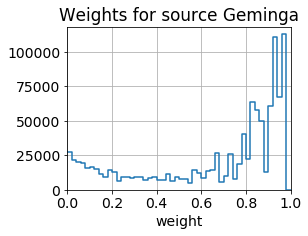

In [ ]:
#collapse-hide
config = Config() 

if config.valid:
    source = PointSource('Geminga')
    print(f'Loading photon data for source {source.name} to test adding weights')
    photon_data = get_photon_data(config,  source )
    h = add_weights(config, photon_data, source)
    print(f'Head of modified photon_data\n {photon_data.head()}')
    plt.rc('font',size=14)
    fig, ax =plt.subplots(figsize=(4,3))
    n = len(h)
    ax.step( np.linspace(0,1, n+1) , np.concatenate([[h[0]], h])); 
    ax.grid();
    ax.set(xlabel='weight', xlim=(0,1), ylim=(0,None))
    #plt.hist(photon_data.weight.values, np.linspace(0,1,51), histtype='stepfilled', lw=2)
    plt.title(f'Weights for source {source.name}')
else:
    print('Not testing since no files.')

In [ ]:
show_doc?

Signature:
show_doc(
    elt,
    doc_string=True,
    name=None,
    title_level=None,
    disp=True,
    default_cls_level=2,
)
Docstring: Show documentation for element `elt`. Supported types: class, function, and enum.
File:      /mnt/c/users/thbur/OneDrive/work/nbdev/nbdev/showdoc.py
Type:      function


In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_effective_area.ipynb.
Converted 02_gti.ipynb.
Converted 03_exposure.ipynb.
Converted 04_photon_data.ipynb.
Converted 05_weights.ipynb.
Converted 06_poisson.ipynb.
Converted 07_cells.ipynb.
Converted 08_loglike.ipynb.
Converted 09_lightcurve.ipynb.
Converted 10_simulation.ipynb.
Sat Dec 26 14:39:00 PST 2020
